Selected model uses word to vec (w2v) for embedding and one LSTM layer. 

Training was done using sentiment140 dataset. 

Taken from: https://www.kaggle.com/paoloripamonti/twitter-sentiment-analysis/notebook

In [ ]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

     |████████████████████████████████| 24.2MB 1.5MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.1.4)


In [ ]:
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Settings

In [ ]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

Read Dataset

Dataset details
target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
ids: The id of the tweet ( 2087)
date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
flag: The query (lyx). If there is no query, then this value is NO_QUERY.
user: the user that tweeted (robotickilldozr)
text: the text of the tweet (Lyx is cool)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#dataset_filename = os.listdir("../input")[0]
#dataset_path = os.path.join("..","input",dataset_filename)
dataset_path = "/content/drive/My Drive/module 3/input/training.1600000.processed.noemoticon.csv"
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: /content/drive/My Drive/module 3/input/training.1600000.processed.noemoticon.csv


In [ ]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [ ]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Map target label to String
0 -> NEGATIVE
2 -> NEUTRAL
4 -> POSITIVE

In [ ]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 517 ms, sys: 0 ns, total: 517 ms
Wall time: 520 ms


(array([     0., 100000., 200000., 300000., 400000., 500000., 600000.,
        700000., 800000., 900000.]),
 <a list of 10 Text major ticklabel objects>)

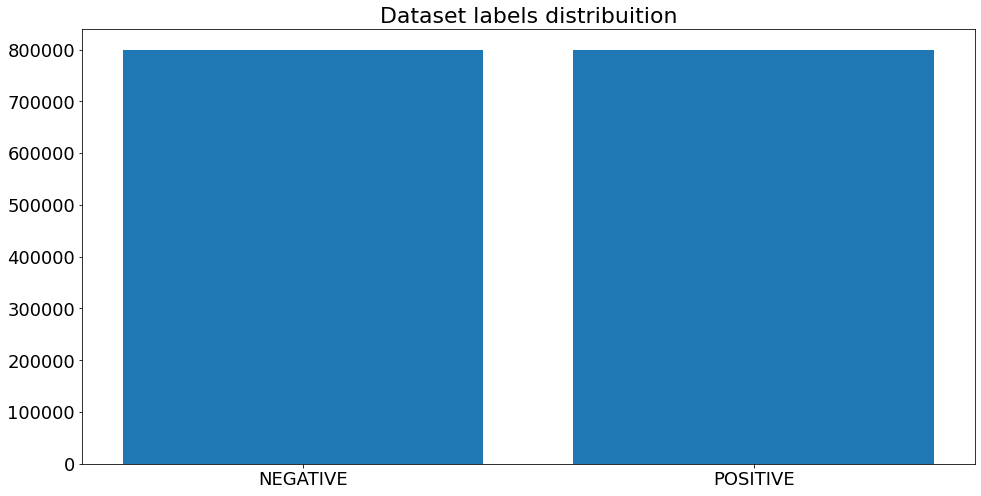

In [ ]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition", fontsize=22)
plt.xticks(fontsize= 18) 
plt.yticks(fontsize=18)

Pre-processing

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 43.1 s, sys: 163 ms, total: 43.3 s
Wall time: 43.3 s


Split train and test

In [ ]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


Word2Vec

In [ ]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 2.42 s, sys: 322 ms, total: 2.75 s
Wall time: 2.75 s


In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [ ]:
w2v_model.build_vocab(documents)

2020-11-09 18:37:18,924 : INFO : collecting all words and their counts
2020-11-09 18:37:18,926 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-11-09 18:37:18,955 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2020-11-09 18:37:18,978 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2020-11-09 18:37:19,003 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2020-11-09 18:37:19,025 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2020-11-09 18:37:19,050 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2020-11-09 18:37:19,073 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2020-11-09 18:37:19,098 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2020-11-09 18:37:19,120 : INFO : PROGRESS: at s

In [ ]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-11-09 18:37:27,906 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-11-09 18:37:28,934 : INFO : EPOCH 1 - PROGRESS: at 4.34% examples, 351654 words/s, in_qsize 13, out_qsize 2
2020-11-09 18:37:29,936 : INFO : EPOCH 1 - PROGRESS: at 9.01% examples, 366957 words/s, in_qsize 16, out_qsize 2
2020-11-09 18:37:30,965 : INFO : EPOCH 1 - PROGRESS: at 14.54% examples, 392115 words/s, in_qsize 15, out_qsize 0
2020-11-09 18:37:32,097 : INFO : EPOCH 1 - PROGRESS: at 19.51% examples, 383898 words/s, in_qsize 12, out_qsize 4
2020-11-09 18:37:33,102 : INFO : EPOCH 1 - PROGRESS: at 24.82% examples, 393773 words/s, in_qsize 13, out_qsize 2
2020-11-09 18:37:34,159 : INFO : EPOCH 1 - PROGRESS: at 29.48% examples, 388465 words/s, in_qsize 16, out_qsize 2
2020-11-09 18:37:35,172 : INFO : EPOCH 1 - PROGRESS: at 34.68% examples, 393175 words/s, in_qsize 15, out_qsize 0
2020-11-09 18:37:36,181 : INFO : EPOCH 1 - PROGRESS: a

CPU times: user 21min 7s, sys: 4.43 s, total: 21min 11s
Wall time: 10min 51s


(263126602, 295270528)

In [ ]:
w2v_model.most_similar("love")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-11-09 18:48:19,487 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.565497875213623),
 ('loves', 0.5618025064468384),
 ('loved', 0.5340549945831299),
 ('adore', 0.5160211324691772),
 ('amazing', 0.5048694014549255),
 ('looove', 0.4900197982788086),
 ('loveee', 0.4733489751815796),
 ('awesome', 0.4592171907424927),
 ('lovee', 0.4453076422214508),
 ('loooove', 0.4440814256668091)]

Tokenize text

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 14.7 s, sys: 43.5 ms, total: 14.8 s
Wall time: 14.8 s


In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 22.5 s, sys: 479 ms, total: 22.9 s
Wall time: 22.9 s


Label encoder

In [ ]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [ ]:
y_train[:10]


array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

Embedding layer

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

Build model

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2020-11-09 18:49:05,464 : WARNING : Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87125700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


Compile model

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Callbacks

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

Train

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
1125/1125 [==============================] - 581s 517ms/step - loss: 0.4704 - accuracy: 0.7734 - val_loss: 0.4519 - val_accuracy: 0.7868
Epoch 2/8
1125/1125 [==============================] - 574s 510ms/step - loss: 0.4676 - accuracy: 0.7749 - val_loss: 0.4502 - val_accuracy: 0.7884
Epoch 3/8
1125/1125 [==============================] - 574s 510ms/step - loss: 0.4651 - accuracy: 0.7764 - val_loss: 0.4487 - val_accuracy: 0.7887
Epoch 4/8
1125/1125 [==============================] - 574s 510ms/step - loss: 0.4635 - accuracy: 0.7773 - val_loss: 0.4465 - val_accuracy: 0.7899
Epoch 5/8
1125/1125 [==============================] - 578s 514ms/step - loss: 0.4617 - accuracy: 0.7782 - val_loss: 0.4469 - val_accuracy: 0.7898
Epoch 6/8
1125/1125 [==============================] - 576s 512ms/step - loss: 0.4610 - accuracy: 0.7785 - val_loss: 0.4438 - val_accuracy: 0.7912
Epoch 7/8
1125/1125 [==============================] - 572s 509ms/step - loss: 0.4600 - accuracy: 0.7790 - val_loss: 0

Evaluate

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 53s 171ms/step - loss: 0.4432 - accuracy: 0.7921

ACCURACY: 0.7920812368392944
LOSS: 0.44319844245910645
CPU times: user 47.9 s, sys: 3.86 s, total: 51.8 s
Wall time: 53.9 s


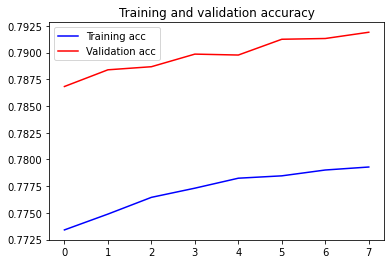

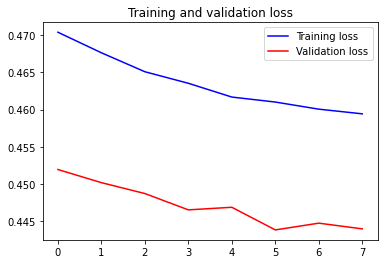

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

Predict

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
predict("i don't know what i'm doing")

{'elapsed_time': 0.3263859748840332,
 'label': 'NEGATIVE',
 'score': 0.3390619456768036}

In [ ]:
predict("What's the difference between a porcupine and a Tesla? A porcupine has pricks on the outside!")

{'elapsed_time': 0.12227439880371094,
 'label': 'NEUTRAL',
 'score': 0.4680527448654175}

In [ ]:
predict("Nothing better than that new car smell, also bonus for saving the planet #tesla")

{'elapsed_time': 0.11312723159790039,
 'label': 'POSITIVE',
 'score': 0.833380401134491}

In [ ]:
predict("Looks like sleepy Joe is gonna win the election.")

{'elapsed_time': 0.11556482315063477,
 'label': 'NEGATIVE',
 'score': 0.34324395656585693}

In [ ]:
predict("There's a general decline in the performance of stocks but facebook happens to pull through lately")

{'elapsed_time': 0.11802268028259277,
 'label': 'NEGATIVE',
 'score': 0.33320504426956177}

In [ ]:
predict("That car looks different, it must be a Tesla!")

{'elapsed_time': 0.1142735481262207,
 'label': 'NEUTRAL',
 'score': 0.47223761677742004}

In [ ]:
predict("It's definitely a year of pandemics, even with stocks the unexpected happens. Airbnb beats Tesla to it! Airbnb is definitely the right stock!")

{'elapsed_time': 0.1173868179321289,
 'label': 'NEUTRAL',
 'score': 0.6805596351623535}

In [ ]:
predict("Alex Trebeck dies at 80. He brought so much joy to so many viewers over his long career in television")

{'elapsed_time': 0.12304043769836426,
 'label': 'NEGATIVE',
 'score': 0.2671782970428467}

In [ ]:
predict("Warren Buffett unloads 60 million dollars worth of airline stocks")

{'elapsed_time': 0.6287031173706055,
 'label': 'POSITIVE',
 'score': 0.7035620212554932}

In [ ]:
predict("Warren Buffett sells 60 million dollars worth of airline stocks")

{'elapsed_time': 0.1217193603515625,
 'label': 'POSITIVE',
 'score': 0.7129901647567749}

In [ ]:
predict("McDonald’s announced it will develop its own line of plant-based burgers, dealing a blow to Beyond Meat and Impossible Foods")

{'elapsed_time': 0.12472391128540039,
 'label': 'NEGATIVE',
 'score': 0.37831494212150574}

In [ ]:
predict("Richard Branson's Virgin Hyperloop conducted its first test with passengers in a hyperloop pod")

{'elapsed_time': 0.11225533485412598,
 'label': 'POSITIVE',
 'score': 0.7107508182525635}

In [ ]:
predict("The F-35 Lightning II is juuuust bigger than the Airbus A400m")

{'elapsed_time': 0.12157106399536133,
 'label': 'NEGATIVE',
 'score': 0.2043319195508957}

Confusion matrix

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

NameError: ignored

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

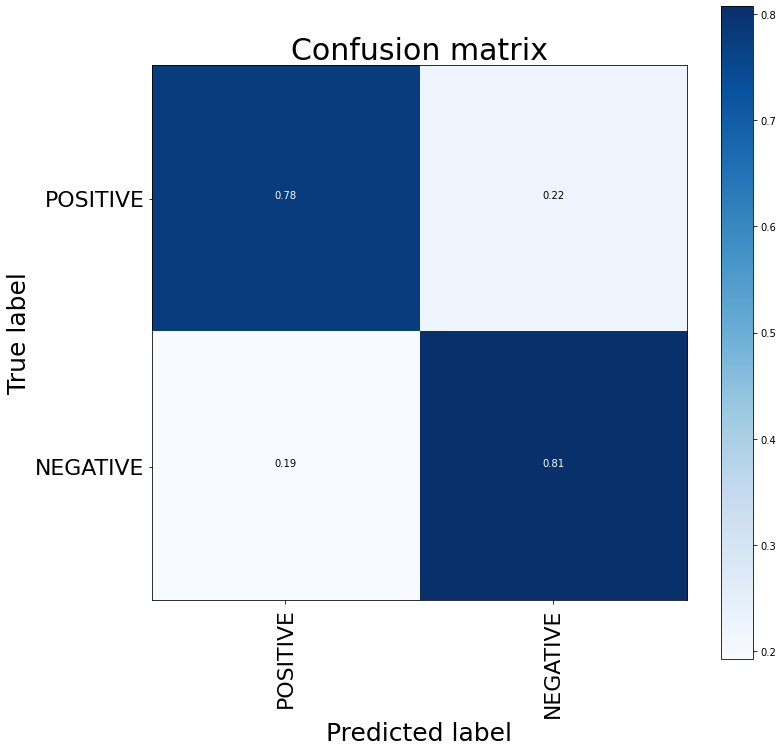

CPU times: user 1.12 s, sys: 34.7 ms, total: 1.15 s
Wall time: 1.17 s


In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

Classification report

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.80      0.78      0.79    159494
    POSITIVE       0.78      0.81      0.80    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [ ]:
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [ ]:
def model_Evaluate(model):

    # Predict values for Test dataset
    y_pred_1d = []
    y_test_1d = list(df_test.target)
    scores = model.predict(x_test)
    y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test_1d, y_pred_1d))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test_1d, y_pred_1d)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

    NEGATIVE       0.80      0.78      0.79    159494
    POSITIVE       0.78      0.81      0.80    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



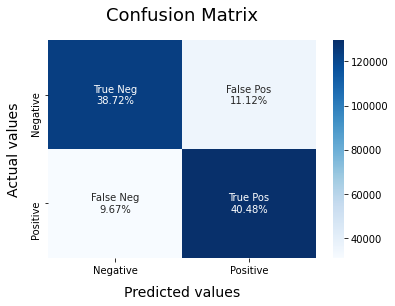

In [ ]:
model_Evaluate(model)

Accuracy score

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

0.79208125

Save model

In [ ]:
model.save("/content/drive/My Drive/module 3/" + KERAS_MODEL)
w2v_model.save("/content/drive/My Drive/module 3/" + WORD2VEC_MODEL)
pickle.dump(tokenizer, open("/content/drive/My Drive/module 3/" + TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open("/content/drive/My Drive/module 3/" + ENCODER_MODEL, "wb"), protocol=0)

2020-11-09 21:13:59,994 : INFO : saving Word2Vec object under /content/drive/My Drive/module 3/model.w2v, separately None
2020-11-09 21:14:00,006 : INFO : not storing attribute vectors_norm
2020-11-09 21:14:00,010 : INFO : not storing attribute cum_table
2020-11-09 21:14:01,378 : INFO : saved /content/drive/My Drive/module 3/model.w2v
